In [1]:
import pandas as pd
temp_rain_soil = pd.read_csv("../AucklandCouncilOpenData_08June24/temp_rain_soil_Auckland_2015-10-21to2024-06-08_15mins.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:15:00,14,0.0,37.364,10.4
2018-07-07 11:30:00,14,0.0,37.594,10.4
2018-07-07 11:45:00,14,0.0,37.590,10.4
2018-07-07 12:00:00,15,0.0,37.587,10.5
2018-07-07 12:15:00,15,0.0,37.584,10.5


In [2]:
temp_rain_soil.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2023-08-23 03:00:00,11,0.0,50.822,11.7
2023-08-23 03:15:00,11,0.0,50.825,11.7
2023-08-23 03:30:00,11,0.0,50.822,11.6
2023-08-23 03:45:00,11,0.0,50.951,11.6
2023-08-23 04:00:00,10,0.0,50.954,11.6


In [3]:
temp_rain_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 179780 entries, 2018-07-07 11:15:00 to 2023-08-23 04:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Temp       179780 non-null  int64  
 1   Rain(mm)   179780 non-null  float64
 2   SoilMoist  179780 non-null  float64
 3   SoilTemp   179780 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 6.9 MB


In [4]:
179780/100 * 80

143824.0

In [5]:
179780/100 * 20

35956.0

In [6]:
train_data = temp_rain_soil.iloc[:143824]
test_data = temp_rain_soil.iloc[143823:]

In [7]:
train_data.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:15:00,14,0.0,37.364,10.4
2018-07-07 11:30:00,14,0.0,37.594,10.4
2018-07-07 11:45:00,14,0.0,37.590,10.4
2018-07-07 12:00:00,15,0.0,37.587,10.5
2018-07-07 12:15:00,15,0.0,37.584,10.5


In [8]:
train_data.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2022-08-13 14:00:00,14,0.0,50.339,12.4
2022-08-13 14:15:00,14,0.0,50.341,12.4
2022-08-13 14:30:00,14,0.0,50.343,12.4
2022-08-13 14:45:00,14,0.0,50.344,12.5
2022-08-13 15:00:00,14,0.0,50.343,12.6


### The choice between additive and multiplicative methods in the Holt-Winters model depends on the nature of the seasonal variations in the dataset.
- Additive Method: Use this method if the seasonal variations are roughly constant over time. In other words, the difference between the peaks and troughs of the seasonal component remains the same throughout the series.

- Multiplicative Method: Use this method if the seasonal variations change proportionally to the level of the series. That is, the amplitude of the seasonal component increases or decreases with the level of the time series.


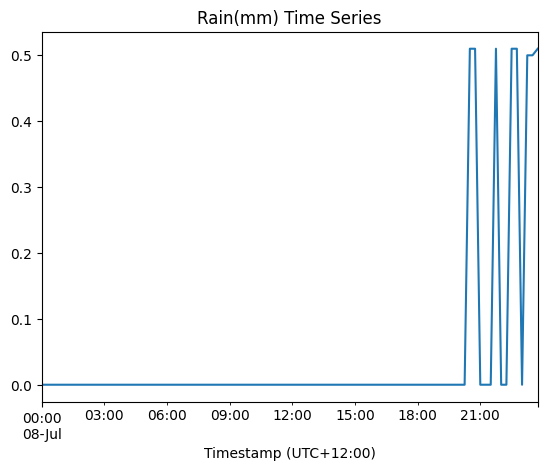

In [9]:
# Visual Inspection to choose between additive and multiplicative method for the Holt-Winters model
import matplotlib.pyplot as plt

# Subset the data for a specific time period
subset = temp_rain_soil['2018-07-08':'2018-07-08 23:45:00']

subset['Rain(mm)'].plot(title='Rain(mm) Time Series')
plt.show()

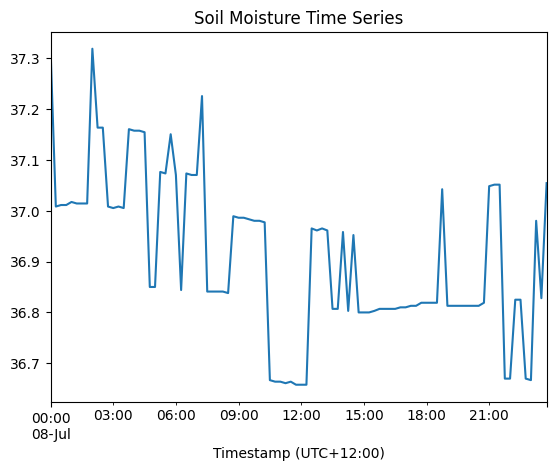

In [10]:
# Visual Inspection to choose between additive and multiplicative method for the Holt-Winters model
import matplotlib.pyplot as plt

subset['SoilMoist'].plot(title='Soil Moisture Time Series')
plt.show()

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model_rain = ExponentialSmoothing(train_data['Rain(mm)'], trend='add', seasonal='add', seasonal_periods=96).fit()
fitted_model_soilmoist = ExponentialSmoothing(train_data['SoilMoist'], trend='mul', seasonal='mul', seasonal_periods=96).fit()

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [12]:
# Forecast the 15-minute interval data for the specified number of days and then aggregate.

forecast_days = 30
forecast_periods_per_day = 96  # 15-minute intervals in a day

# Get the length of the first and last days in the data
first_day_length = len(train_data[train_data.index.date == train_data.index[0].date()])
last_day_length = len(train_data[train_data.index.date == train_data.index[-1].date()])
forecasted_values_rain = []
forecasted_values_soilmoist = []

for i in range(1, forecast_days + 1):
    if i == 1:
        forecast_rain = fitted_model_rain.forecast(first_day_length + forecast_periods_per_day)
        forecast_soilmoist = fitted_model_soilmoist.forecast(first_day_length + forecast_periods_per_day)
    elif i == forecast_days:
        forecast_rain = fitted_model_rain.forecast(last_day_length + (i - 1) * forecast_periods_per_day)
        forecast_soilmoist = fitted_model_soilmoist.forecast(last_day_length + (i - 1) * forecast_periods_per_day)
    else:
        forecast_rain = fitted_model_rain.forecast(i * forecast_periods_per_day)
        forecast_soilmoist = fitted_model_soilmoist.forecast(i * forecast_periods_per_day)

    forecasted_values_rain.append(forecast_rain)
    forecasted_values_soilmoist.append(forecast_soilmoist)

In [13]:
# Concatenate all forecasted values
forecasted_values_rain = np.concatenate(forecasted_values_rain)
forecasted_values_soilmoist = np.concatenate(forecasted_values_soilmoist)

# Create a date range for the forecast period
forecast_start_date = train_data.index[-1] + pd.Timedelta(minutes=15)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecasted_values_rain), freq='15T')

# Create DataFrames for forecasts
forecast_df_rain = pd.DataFrame({'Rain(mm)': forecasted_values_rain}, index=forecast_dates)
forecast_df_soilmoist = pd.DataFrame({'SoilMoist': forecasted_values_soilmoist}, index=forecast_dates)

# Resample to get daily sums for Rain(mm) and daily means for SoilMoist
daily_forecasts_rain = forecast_df_rain.resample('D').sum()
daily_forecasts_soilmoist = forecast_df_soilmoist.resample('D').mean()

# Print the daily forecasts
print("Daily Rainfall Forecasts:")
print(daily_forecasts_rain)

print("\nDaily Soil Moisture Forecasts:")
print(daily_forecasts_soilmoist)

NameError: name 'np' is not defined

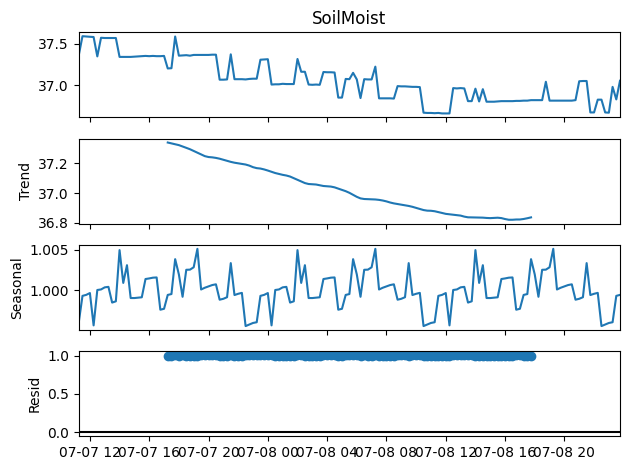

In [ ]:
# Formal Analysis  to choose between additive and multiplicative method for the Holt-Winters model

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(subset['SoilMoist'], model='multiplicative', period=48)
decomposition.plot()
plt.show()



In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
fitted_model = ExponentialSmoothing(train_data['SoilMoist'], trend='mul', seasonal='mul', seasonal_periods=48).fit()

forecast_days = 30
forecast_periods = 96  #  96 periods per day

# Get the length of the first and last days in the data
first_day_length = len(train_data[train_data.index.date == train_data.index[0].date()])
last_day_length = len(train_data[train_data.index.date == train_data.index[-1].date()])
forecasted_values = []

for i in range(1, forecast_days + 1):
    if i == 1:
        forecast = fitted_model.forecast(first_day_length + forecast_periods)
    elif i == forecast_days:
        forecast = fitted_model.forecast(last_day_length + (i - 1) * forecast_periods)
    else:
        forecast = fitted_model.forecast(i * forecast_periods)
    forecasted_values.append(forecast)

for i, forecast in enumerate(forecasted_values, start=1):
    print(f"Forecast for {i} day(s) ahead:")
    print(forecast)
    print()

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Forecast for 1 day(s) ahead:
2022-08-13 15:15:00    50.345544
2022-08-13 15:30:00    50.347056
2022-08-13 15:45:00    50.349561
2022-08-13 16:00:00    50.351573
2022-08-13 16:15:00    50.349108
                         ...    
2022-08-15 02:45:00    50.480536
2022-08-15 03:00:00    50.483038
2022-08-15 03:15:00    50.485579
2022-08-15 03:30:00    50.487095
2022-08-15 03:45:00    50.489607
Freq: 15min, Length: 147, dtype: float64

Forecast for 2 day(s) ahead:
2022-08-13 15:15:00    50.345544
2022-08-13 15:30:00    50.347056
2022-08-13 15:45:00    50.349561
2022-08-13 16:00:00    50.351573
2022-08-13 16:15:00    50.349108
                         ...    
2022-08-15 14:00:00    50.528545
2022-08-15 14:15:00    50.528560
2022-08-15 14:30:00    50.528608
2022-08-15 14:45:00    50.527296
2022-08-15 15:00:00    50.529801
Freq: 15min, Length: 192, dtype: float64

Forecast for 3 day(s) ahead:
2022-08-13 15:15:00    50.345544
2022-08-13 15:30:00    50.347056
2022-08-13 15:45:00    50.349561
2022

In [ ]:
train_data['SoilMoist'].plot(legend=True, label='TRAIN SOIL MOIST', figsize=(12,5))
test_data['SoilMoist'].plot(legend=True, label='TRAIN SOIL MOIST', figsize=(12,5))
forecasted_values['SoilMoist'].plot(legend=True, label='TRAIN SOIL MOIST', figsize=(12,5))